In [45]:
import pandas as pd
import boto3
# import S3FS
import os.path
from pathlib import Path
from pyspark.sql import SparkSession
from boto3.session import Session
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.pyplot import figure
from helper_func import *
pd.set_option('display.max_rows', None)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot


In [2]:
data = pd.read_csv("emscad_v1.csv")

In [3]:
data.drop("in_balanced_dataset", inplace = True, axis = 1)

In [4]:
data["fraudulent"] = data["fraudulent"].replace(["f" , "t"], ["Not Fraud", "Fraud"])

In [5]:
fraud_prop = data.groupby("fraudulent").size().reset_index(name = "counts")
x = np.array(fraud_prop.iloc[:,0])
y = np.array(fraud_prop.iloc[:,1])
total = y.sum()

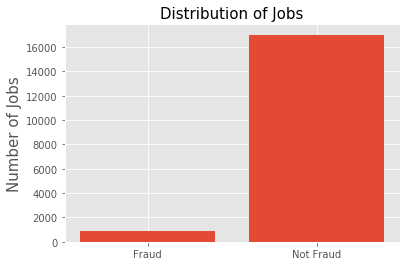

In [6]:
fig = plt.figure()
plt.bar(x, y) 
plt.ylabel("Number of Jobs", fontsize=15) 
plt.title("Distribution of Jobs", fontsize=15)
fig.savefig('images/fraud.png', bbox_inches='tight');

<Figure size 432x288 with 0 Axes>

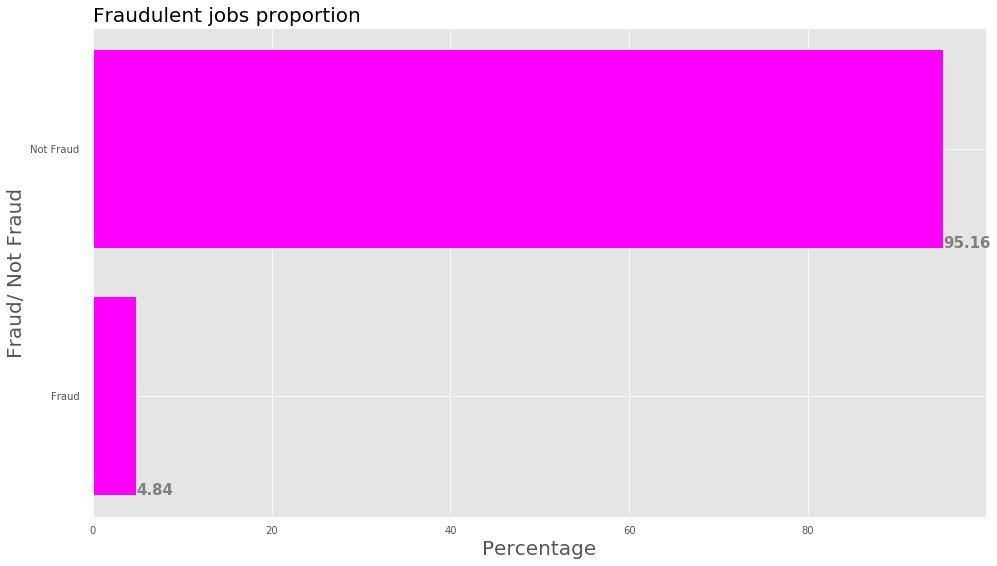

In [7]:
# fraud distribution percentages
fig = plt.figure()
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y*100/total, color="magenta")
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10)
for i in ax.patches: 
    plt.text(i.get_width(), i.get_y(),  
             str(round((i.get_width()), 2)), 
             fontsize = 15, fontweight ='bold', 
             color ='grey')
    
ax.set_title("Fraudulent jobs proportion", 
             loc ='left', fontsize =20) 
ax.set_ylabel("Fraud/ Not Fraud", fontsize =20)
ax.set_xlabel("Percentage", fontsize =20)
fig.savefig('images/fraud_perc.png', bbox_inches='tight')

In [6]:
data["fraudulent"] = data["fraudulent"].replace(["Not Fraud", "Fraud"], [0,1])

binary_cols = ["telecommuting", "has_company_logo","has_questions"]

for col in binary_cols:
    binarize(data,col)



In [7]:
fill_nulls(data)

<Figure size 432x288 with 0 Axes>

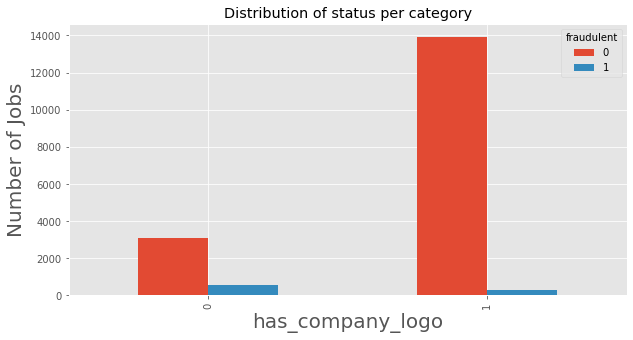

<Figure size 432x288 with 0 Axes>

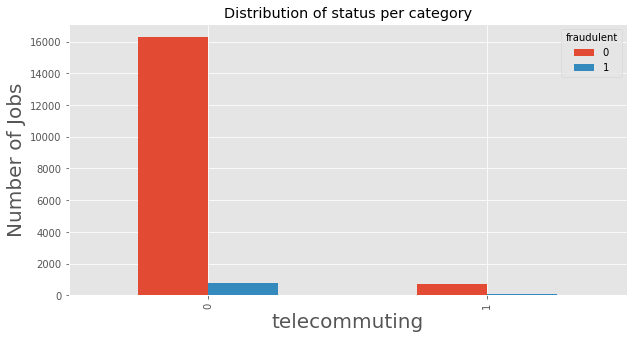

<Figure size 432x288 with 0 Axes>

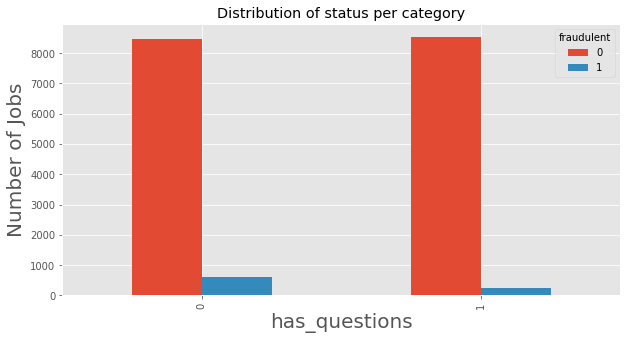

<Figure size 432x288 with 0 Axes>

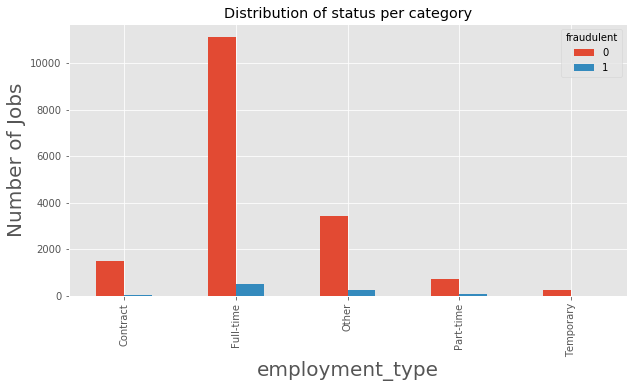

In [10]:
cols = ["has_company_logo","telecommuting", "has_questions", "employment_type" ]

for col in cols:
    plot_bar(data,col)

In [8]:
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]

for col in text_cols:
    clean_cols(data,col)


<Figure size 432x288 with 0 Axes>

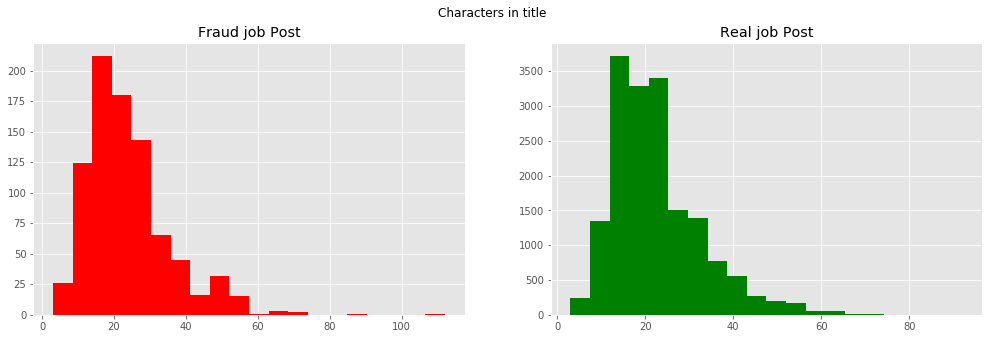

<Figure size 432x288 with 0 Axes>

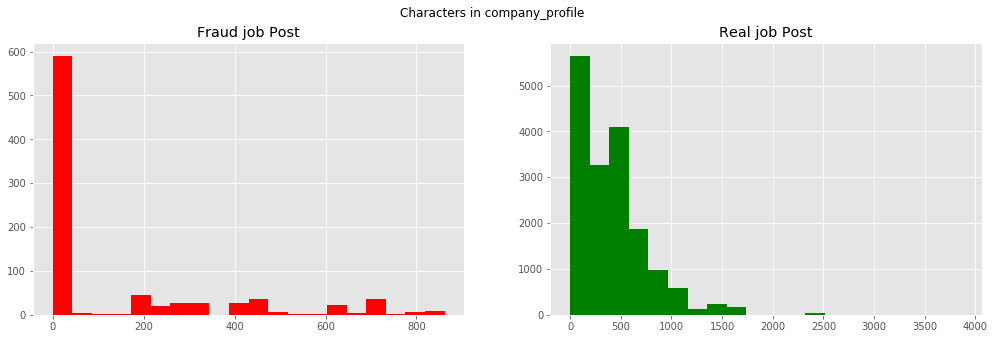

<Figure size 432x288 with 0 Axes>

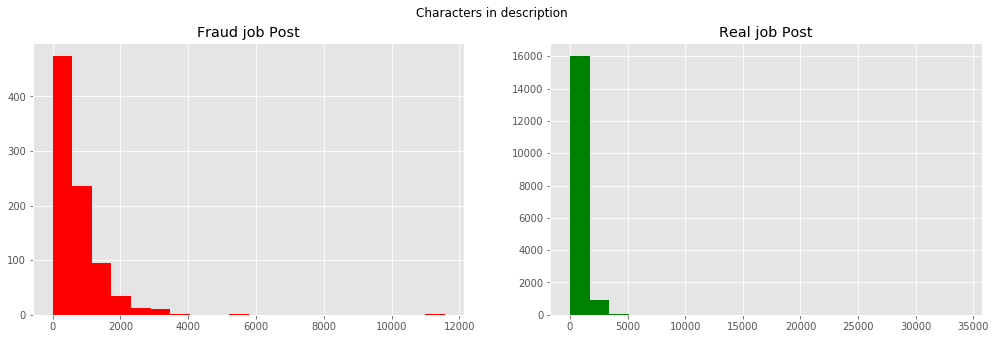

<Figure size 432x288 with 0 Axes>

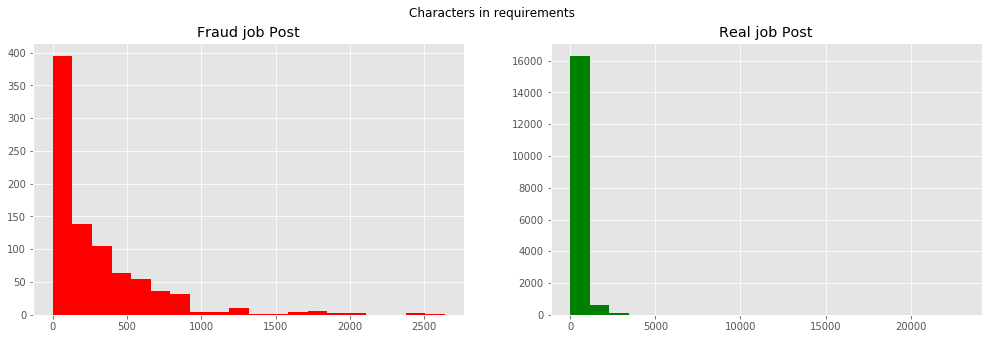

<Figure size 432x288 with 0 Axes>

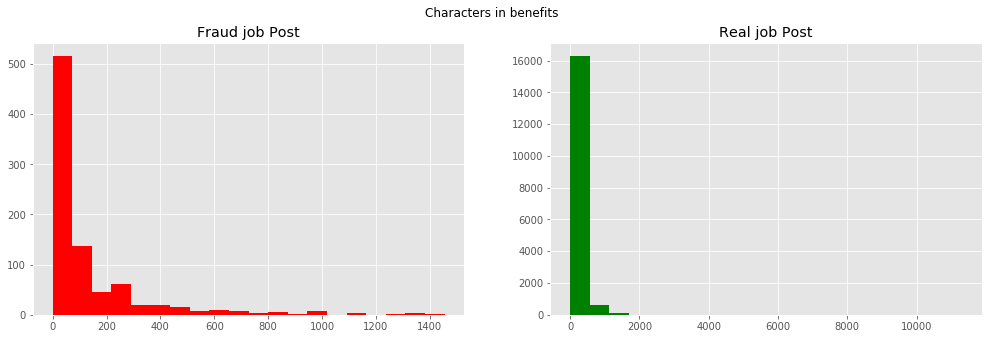

In [13]:
for col in text_cols:
    plot_text(data, col)

<Figure size 432x288 with 0 Axes>

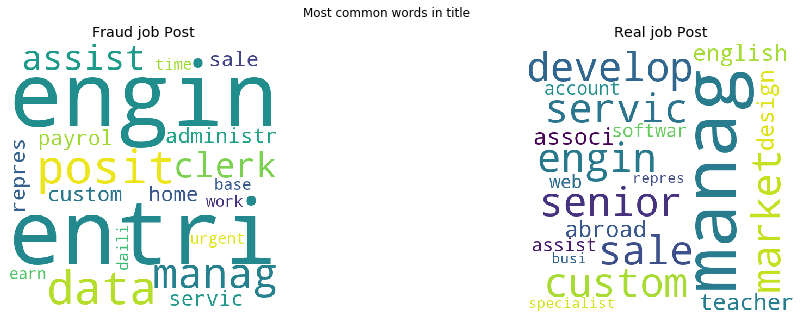

<Figure size 432x288 with 0 Axes>

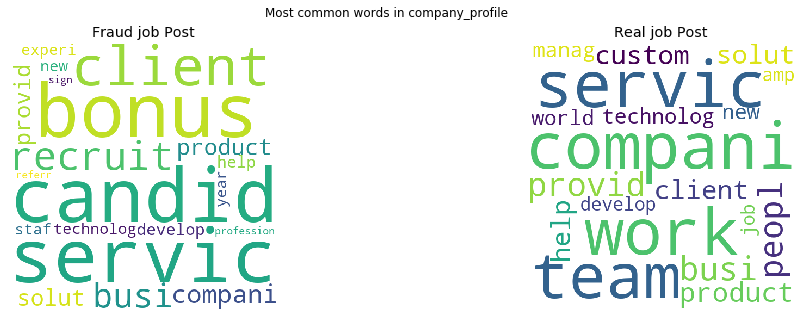

<Figure size 432x288 with 0 Axes>

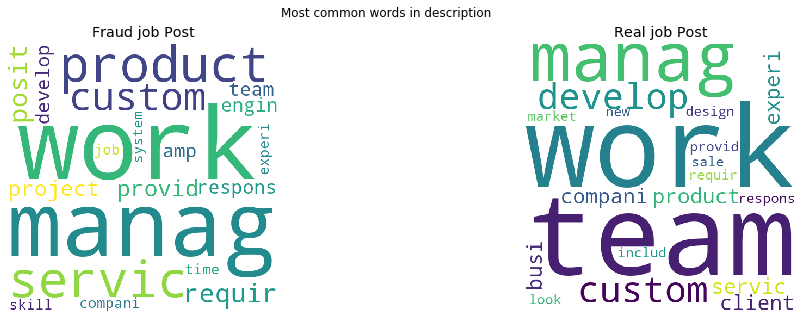

<Figure size 432x288 with 0 Axes>

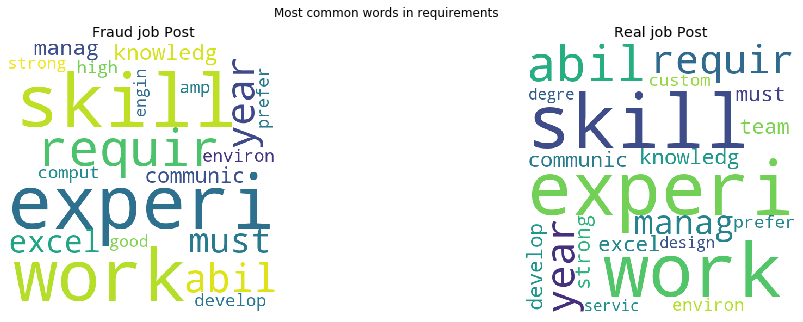

<Figure size 432x288 with 0 Axes>

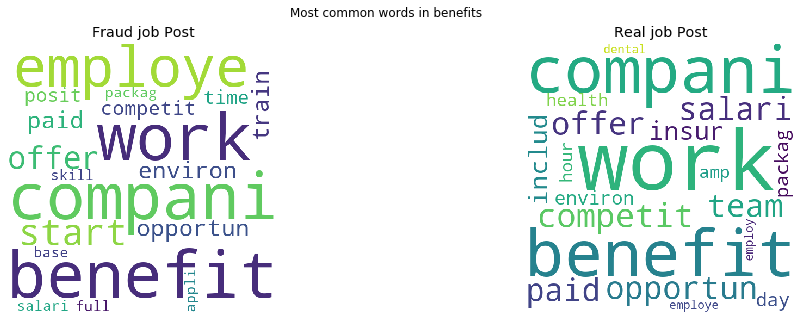

In [14]:
for col in text_cols:
    plot_wordcloud(data, col)

In [11]:
data["text"] = data["title"] + data["company_profile"] + data["description"] + data["requirements"] + data["benefits"]

In [13]:
data.to_pickle("data_text")

## Features Cleaning

In [14]:
df = data.copy()

In [15]:
clean_features(df)


## BASELINE MODEL

In [17]:
# Accuracy is useless in problems with unequal classes and has absolutely no predictive power

In [18]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [19]:
y_actual = np.array(df["fraudulent"])

In [20]:
y_pred0 = np.zeros(len(y_actual))
y_pred1 = np.ones(len(y_actual))
pred_y = np.random.choice([0,1],size=(len(y_actual),), p=[0.95,0.05])

In [21]:
cf = confusion_matrix(y_pred0, y_actual)


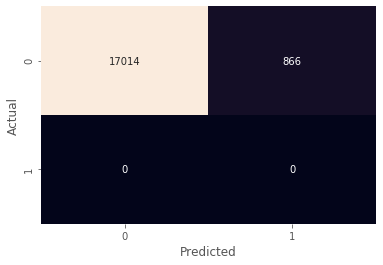

In [22]:
import seaborn as sns
fig = plt.figure()
ax = sns.heatmap(cf, annot=True, cbar=False, fmt='g')
ax.set(xlabel='Predicted', ylabel='Actual')
fig.savefig("images/conf_matrix", bbox_inches='tight')
plt.show()

### Baseline Results

In [23]:
#no frauds
generate_model_report(y_actual, y_pred0)

Accuracy: 0.952
Precision: 0.000
Recall: 0.000
F1 score: 0.000


/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
#all frauds
generate_model_report(y_actual, y_pred1)

Accuracy: 0.048
Precision: 0.048
Recall: 1.000
F1 score: 0.092


In [25]:
# random prediction
generate_model_report(y_actual,pred_y)

Accuracy: 0.906
Precision: 0.061
Recall: 0.066
F1 score: 0.063


In [26]:
# All categories value except 'department', 'function'

fit_df = df[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'text', 'fraudulent']]


,location,industry,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,text,fraudulent
0,US,Not Specified,Not Specified,0,1,0,Other,Internship,Unspecified,market internwere food52 weve creat groundbrea...,0
1,NZ,Marketing and Advertising,Not Specified,0,1,0,Full-time,Not Applicable,Unspecified,custom servic cloud video product90 second wor...,0
2,US,Not Specified,Not Specified,0,1,0,Other,NotSpecified,Unspecified,commiss machineri assist cmavalor servic provi...,0
3,US,IT,Not Specified,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,account execut washington dcpassion improv qua...,0
4,US,Health Care,Not Specified,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,bill review managspotsourc solut llc global hu...,0


In [27]:
cat_df = fit_df[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'fraudulent']]

fit_df_dummy = pd.get_dummies(cat_df)



In [28]:
text_cat_df = pd.concat([fit_df_dummy, fit_df["text"]], axis = 1)


In [44]:
text_cat_df.to_pickle("cleaned_textCol.pkl")

## To balance or not to balance

0    17014
1      866
Name: fraudulent, dtype: int64


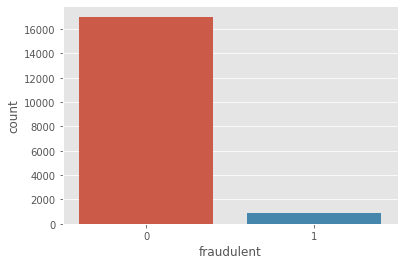

In [29]:
## Split first to avoid leakage and to handle imbalance


X = text_cat_df.drop("fraudulent", axis=1)
y = text_cat_df["fraudulent"]

X_cat, y_cat = fit_df_dummy.drop("fraudulent", axis=1), fit_df_dummy["fraudulent"]

# splitting text and categorical columns
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = .20, random_state=1)

#splitting only categorical columns
X_cat_train, X_cat_test, y_cat_train,y_cat_test = train_test_split(X_cat, y_cat, stratify=y , test_size = .20, random_state=1)


ax = sns.countplot(x = y, data = X)
print(y.value_counts())

# before balancing the data


## SMOTE

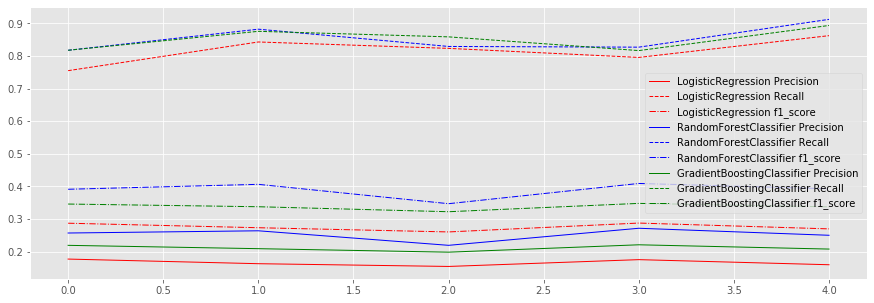

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators, X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='undersampling' )
ax.legend()

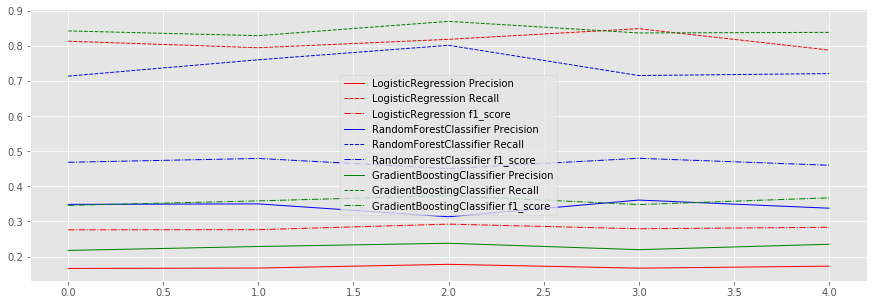

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='oversampling' )
ax.legend()

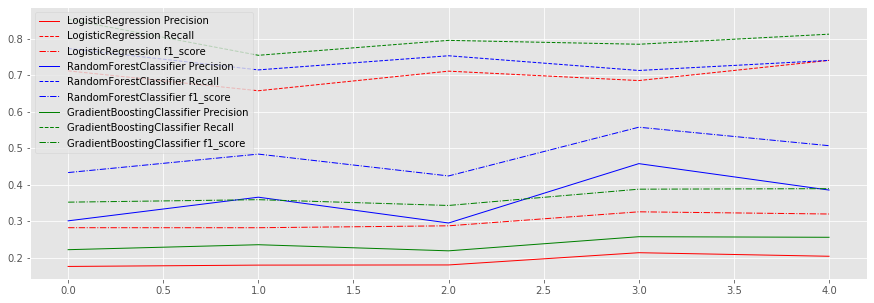

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='smote' )
ax.legend()

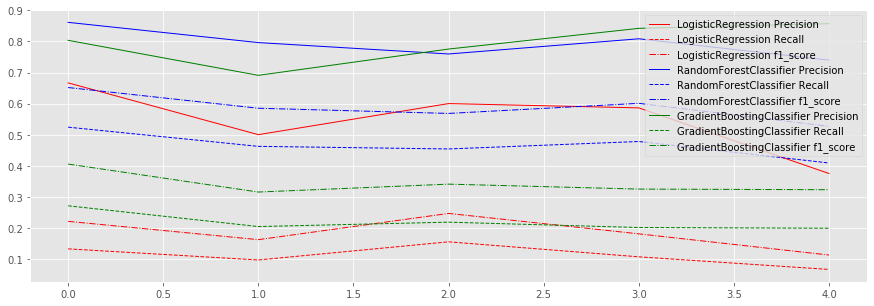

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='None' )
ax.legend()

## Model only with categorical features

RandomForestClassifier F1 Score:  0.619
RandomForestClassifier PR AUC: 0.685
Accuracy: 0.970
Precision: 0.806
Recall: 0.503
F1 score: 0.619


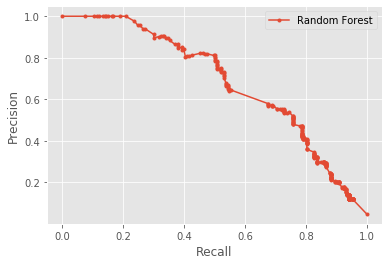

In [113]:
model = RandomForestClassifier()
model.fit(X_cat_train, y_cat_train)

yhat = model.predict_proba(X_cat_test)
pos_probs = yhat[:, 1]


y_pred = model.predict(X_cat_test)


# calculate the precision-recall auc
precision, recall, thresholds = precision_recall_curve(y_cat_test, pos_probs)
F1_Score = f1_score(y_cat_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Random Forest')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)

generate_model_report(y_cat_test, y_pred)
cm = confusion_matrix(y_cat_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

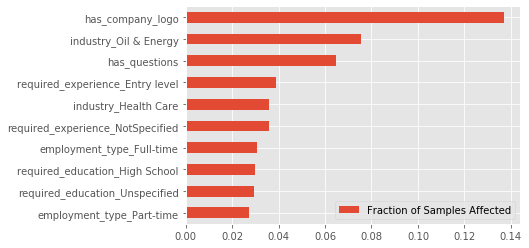

In [118]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=X_cat_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False)
y = feat_scores[:10]
y[::-1].plot(kind='barh')
fig.savefig(f"images/cat_feature_imp", bbox_inches='tight');

## TFIDF vectorization

In [34]:
tfidf = TfidfVectorizer(max_features = 2000)

In [35]:
tfidf_matrix_train = tfidf.fit_transform(X_train.text.values.astype('U'))

In [36]:
tfidf_matrix_test =  tfidf.transform(X_test.text.values.astype('U'))

In [37]:
nlp_train = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf.get_feature_names())
nlp_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=tfidf.get_feature_names())

In [38]:
nlp_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
cat_nlp_train = pd.concat([nlp_train, X_train], axis=1)

nlp_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
cat_nlp_test = pd.concat([nlp_test, X_test], axis=1)

In [39]:
cat_nlp_train = cat_nlp_train.drop("text", axis=1)
cat_nlp_test = cat_nlp_test.drop("text", axis=1);

No Skill F1 Score: 0.043
No Skill PR AUC: 0.089
Accuracy: 0.914
Precision: 0.047
Recall: 0.040
F1 score: 0.043


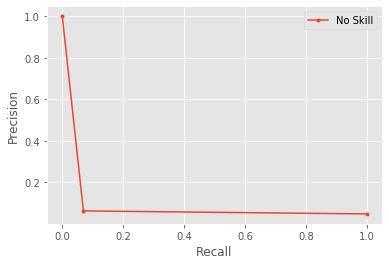

In [40]:
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot


# setting up a dummy model
model = DummyClassifier(strategy='stratified')  #Predict 0 or 1 proportional to the prior probability in the dataset 
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
y_pred = model.predict(cat_nlp_test)
pos_probs = yhat[:, 1]



# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='No Skill')
print('No Skill F1 Score: %.3f' % F1_Score)
print('No Skill PR AUC: %.3f' % auc_score)

generate_model_report(y_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.250000, F-Score=0.858
Best Threshold=0.250000, Precision=0.899, Recall=0.821




RandomForestClassifier F1 Score:  0.746
RandomForestClassifier PR AUC: 0.911
Accuracy: 0.980
Precision: 1.000
Recall: 0.595
F1 score: 0.746


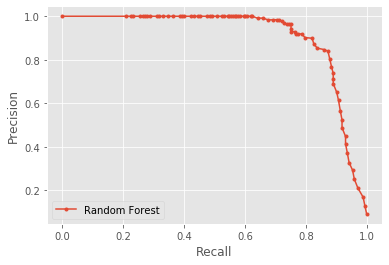

In [133]:
model = RandomForestClassifier()
model.fit(cat_nlp_train, y_train)

yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]


y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, thresholds = precision_recall_curve(y_test, pos_probs)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Best Threshold=%f, Precision=%.3f, Recall=%.3f'  % (thresholds[ix], precision[ix], recall[ix]))
print("\n\n\n")
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Random Forest')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)

generate_model_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

<Figure size 432x288 with 0 Axes>

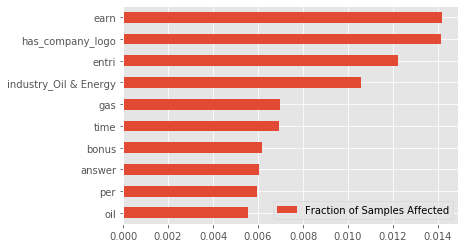

In [128]:
# Plot the feature importance
fig = plt.figure()
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=cat_nlp_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending = False)[:10]
y = feat_scores[:10]
y[::-1].plot(kind="barh")
fig.savefig(f"images/text_feature_imp", bbox_inches='tight');

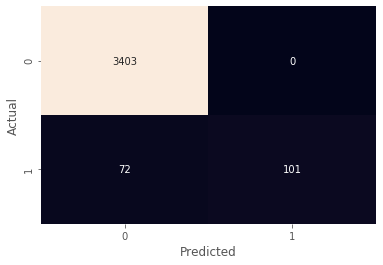

In [49]:
import seaborn as sns
fig = plt.figure()
ax = sns.heatmap(cm , annot=True, cbar=False, fmt='g')
ax.set(xlabel='Predicted', ylabel='Actual')
fig.savefig("images/conf_matrix", bbox_inches='tight')
plt.show()

GradientBoostingClassifier F1 Score:  0.671
GradientBoostingClassifier PR AUC: 0.749
Accuracy: 0.974
Precision: 0.864
Recall: 0.549
F1 score: 0.671


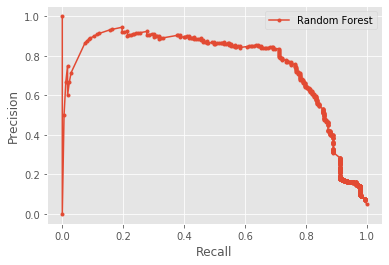

In [42]:
model = GradientBoostingClassifier()
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]
y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Gradient Boosting')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)
generate_model_report(y_test, y_pred)



# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

LogisticRegression F1 Score:  0.664
LogisticRegression PR AUC: 0.789
Accuracy: 0.974
Precision: 0.901
Recall: 0.526
F1 score: 0.664


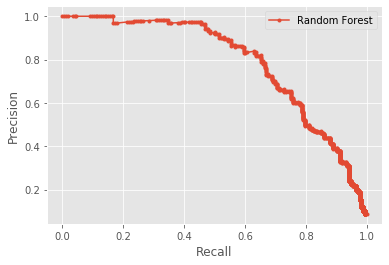

In [43]:
model = LogisticRegression(max_iter=500)
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]
y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Logistic Regression')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)
generate_model_report(y_test, y_pred)


# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()